# News Classifier Agent - Exploratory Data Analysis

**Purpose:** Explore the news dataset and prototype zero-shot classification before running formal MLflow experiments.

**Workflow:**
1. 📊 **Exploration (This Notebook)** - Understand data, test prompts
2. 🔬 **Experimentation (MLproject)** - Run tracked experiments with `mlflow run`
3. 🚀 **Production (MLproject)** - Deploy winning model

---

## Setup

In [1]:
import json
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Add parent directory to path
sys.path.append('..')

# Load environment variables
load_dotenv('../config/.env')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Setup complete")

✓ Setup complete


## 1. Load and Explore the Dataset

In [2]:
# Load sample news data
data_path = '../data/sample_news.json'
with open(data_path, 'r') as f:
    news_data = json.load(f)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(news_data)

print(f"Dataset size: {len(df)} articles")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset size: 10 articles

Columns: ['id', 'title', 'content', 'expected_category', 'expected_sentiment']

First few rows:


,id,title,content,expected_category,expected_sentiment
0,1,Major Tech Company Announces AI Breakthrough,A leading technology company unveiled its late...,Technology,Positive
1,2,Global Markets Experience Sharp Decline,Stock markets around the world fell sharply to...,Business,Negative
2,3,Championship Game Ends in Overtime Thriller,"In an electrifying finish, the home team secur...",Sports,Positive
3,4,New Study Reveals Climate Change Impact on Coa...,Researchers published findings showing that se...,Science,Negative
4,5,Film Festival Showcases Independent Cinema,The annual film festival concluded this weeken...,Entertainment,Positive


### Dataset Statistics

In [3]:
# Article length statistics
df['title_length'] = df['title'].str.len()
df['content_length'] = df['content'].str.len()
df['word_count'] = df['content'].str.split().str.len()

print("Article Length Statistics:")
print(df[['title_length', 'content_length', 'word_count']].describe())

Article Length Statistics:
       title_length  content_length  word_count
count     10.000000        10.00000   10.000000
mean      46.200000       329.30000   44.300000
std        8.093893        23.16151    4.571652
min       35.000000       297.00000   38.000000
25%       42.250000       309.25000   41.500000
50%       43.500000       331.50000   44.000000
75%       51.750000       348.00000   45.750000
max       60.000000       360.00000   52.000000


### Category Distribution

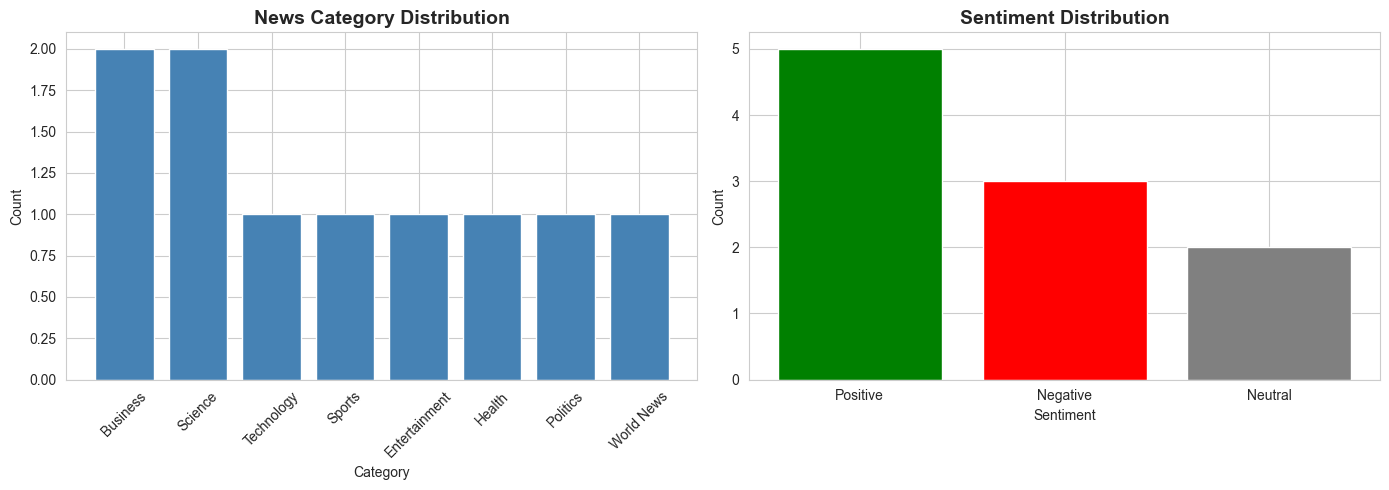


Categories: {'Business': 2, 'Science': 2, 'Technology': 1, 'Sports': 1, 'Entertainment': 1, 'Health': 1, 'Politics': 1, 'World News': 1}
Sentiments: {'Positive': 5, 'Negative': 3, 'Neutral': 2}


In [4]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category distribution
category_counts = df['expected_category'].value_counts()
axes[0].bar(category_counts.index, category_counts.values, color='steelblue')
axes[0].set_title('News Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Sentiment distribution
sentiment_counts = df['expected_sentiment'].value_counts()
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
sentiment_colors = [colors.get(s, 'blue') for s in sentiment_counts.index]
axes[1].bar(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors)
axes[1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nCategories: {category_counts.to_dict()}")
print(f"Sentiments: {sentiment_counts.to_dict()}")

### Sample Articles by Category

In [5]:
# Show one example from each category
print("Sample Articles by Category:\n")
for category in df['expected_category'].unique():
    article = df[df['expected_category'] == category].iloc[0]
    print(f"{'='*80}")
    print(f"Category: {category} | Sentiment: {article['expected_sentiment']}")
    print(f"{'='*80}")
    print(f"Title: {article['title']}")
    print(f"\nContent: {article['content'][:200]}...")
    print()

Sample Articles by Category:

Category: Technology | Sentiment: Positive
Title: Major Tech Company Announces AI Breakthrough

Content: A leading technology company unveiled its latest artificial intelligence model today, claiming significant improvements in natural language understanding. The new model demonstrates enhanced reasoning...

Category: Business | Sentiment: Negative
Title: Global Markets Experience Sharp Decline

Content: Stock markets around the world fell sharply today amid concerns about rising interest rates and inflation. The Dow Jones Industrial Average dropped 2.3%, while European and Asian markets also saw sign...

Category: Sports | Sentiment: Positive
Title: Championship Game Ends in Overtime Thriller

Content: In an electrifying finish, the home team secured victory in overtime during last night's championship game. The crowd of over 70,000 fans erupted as the winning goal was scored in the final seconds. B...

Category: Science | Sentiment: Negative
Title: New S

## 2. Test Zero-Shot Classification Prompts

Let's prototype different prompt formats to see what works best.

In [6]:
# Load our prompt templates
from config.news_categories import (
    NEWS_CATEGORIES,
    SENTIMENT_CATEGORIES,
    CLASSIFICATION_PROMPT_TEMPLATE,
    SENTIMENT_PROMPT_TEMPLATE,
    COMBINED_PROMPT_TEMPLATE
)

print("Available Categories:")
print(NEWS_CATEGORIES)
print("\nAvailable Sentiments:")
print(SENTIMENT_CATEGORIES)

Available Categories:
['Politics', 'Technology', 'Business', 'Sports', 'Entertainment', 'Health', 'Science', 'World News']

Available Sentiments:
['Positive', 'Neutral', 'Negative']


### Example: Combined Prompt (Category + Sentiment)

In [7]:
# Test prompt with a sample article
test_article = df.iloc[0]

prompt = COMBINED_PROMPT_TEMPLATE.format(
    categories=", ".join(NEWS_CATEGORIES),
    sentiments=", ".join(SENTIMENT_CATEGORIES),
    title=test_article['title'],
    content=test_article['content']
)

print("Example Prompt:")
print("="*80)
print(prompt)
print("="*80)
print(f"\nExpected Output:")
print(f"Category: {test_article['expected_category']}")
print(f"Sentiment: {test_article['expected_sentiment']}")

Example Prompt:
You are a news analysis expert. Analyze the following news article and provide both category and sentiment.

Categories: Politics, Technology, Business, Sports, Entertainment, Health, Science, World News
Sentiments: Positive, Neutral, Negative

News Article:
Title: Major Tech Company Announces AI Breakthrough
Content: A leading technology company unveiled its latest artificial intelligence model today, claiming significant improvements in natural language understanding. The new model demonstrates enhanced reasoning capabilities and reduced hallucinations compared to previous versions. Industry experts are calling it a potential game-changer for enterprise AI applications.

Instructions:
1. Classify the article into the most appropriate category
2. Determine the overall sentiment
3. Respond in this exact format:
   Category: <category_name>
   Sentiment: <sentiment_name>

Response:

Expected Output:
Category: Technology
Sentiment: Positive


## 3. Prototype with External Model (OpenAI)

Quick prototype to test if zero-shot classification works.

In [8]:
from openai import OpenAI

# Initialize OpenAI client
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    print("⚠️ OPENAI_API_KEY not set in .env file")
    print("Skipping OpenAI prototype...")
else:
    client = OpenAI(api_key=openai_api_key)
    print("✓ OpenAI client initialized")

✓ OpenAI client initialized


In [9]:
def classify_with_openai(title: str, content: str, model: str = "gpt-4o-mini"):
    """Quick prototype classification function"""
    prompt = COMBINED_PROMPT_TEMPLATE.format(
        categories=", ".join(NEWS_CATEGORIES),
        sentiments=", ".join(SENTIMENT_CATEGORIES),
        title=title,
        content=content
    )
    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a news classification expert."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=100
    )
    
    return response.choices[0].message.content.strip()

# Test on first article
if openai_api_key:
    test_article = df.iloc[0]
    print(f"Testing: {test_article['title'][:50]}...\n")
    
    result = classify_with_openai(test_article['title'], test_article['content'])
    
    print("LLM Response:")
    print(result)
    print(f"\nExpected:")
    print(f"Category: {test_article['expected_category']}")
    print(f"Sentiment: {test_article['expected_sentiment']}")

Testing: Major Tech Company Announces AI Breakthrough...

LLM Response:
Category: Technology  
Sentiment: Positive

Expected:
Category: Technology
Sentiment: Positive


### Test on Multiple Articles

In [10]:
if openai_api_key:
    # Test on first 3 articles to save API costs
    results = []
    
    for idx, article in df.head(3).iterrows():
        print(f"\nClassifying article {idx + 1}/3: {article['title'][:40]}...")
        
        response = classify_with_openai(article['title'], article['content'])
        
        results.append({
            'title': article['title'],
            'expected_category': article['expected_category'],
            'expected_sentiment': article['expected_sentiment'],
            'llm_response': response
        })
    
    # Display results
    results_df = pd.DataFrame(results)
    print("\n" + "="*80)
    print("PROTOTYPE RESULTS (OpenAI)")
    print("="*80)
    display(results_df)


Classifying article 1/3: Major Tech Company Announces AI Breakthr...

Classifying article 2/3: Global Markets Experience Sharp Decline...

Classifying article 3/3: Championship Game Ends in Overtime Thril...

PROTOTYPE RESULTS (OpenAI)


,title,expected_category,expected_sentiment,llm_response
0,Major Tech Company Announces AI Breakthrough,Technology,Positive,Category: Technology \nSentiment: Positive
1,Global Markets Experience Sharp Decline,Business,Negative,Category: Business \nSentiment: Negative
2,Championship Game Ends in Overtime Thriller,Sports,Positive,Category: Sports \nSentiment: Positive


## 4. Prototype with Databricks Foundation Model

Test internal Databricks models (requires Databricks connection).

In [11]:
from databricks.sdk import WorkspaceClient
from databricks.sdk.service.serving import ChatMessage, ChatMessageRole

# Initialize Databricks client
databricks_host = os.getenv('DATABRICKS_HOST')
databricks_token = os.getenv('DATABRICKS_TOKEN')

if not databricks_host or not databricks_token:
    print("⚠️ DATABRICKS_HOST or DATABRICKS_TOKEN not set in .env file")
    print("Skipping Databricks prototype...")
else:
    db_client = WorkspaceClient(host=databricks_host, token=databricks_token)
    print("✓ Databricks client initialized")
    
    # Verify connection
    try:
        user = db_client.current_user.me()
        print(f"✓ Connected as: {user.user_name}")
    except Exception as e:
        print(f"✗ Connection failed: {e}")

✓ Databricks client initialized
✓ Connected as: samlexrod@gmail.com


In [15]:
def classify_with_databricks(title: str, content: str, model: str = "databricks-gpt-oss-20b"):
    """Quick prototype classification function for Databricks"""
    prompt = COMBINED_PROMPT_TEMPLATE.format(
        categories=", ".join(NEWS_CATEGORIES),
        sentiments=", ".join(SENTIMENT_CATEGORIES),
        title=title,
        content=content
    )
    
    messages = [
        ChatMessage(
            role=ChatMessageRole.SYSTEM,
            content="You are a news classification expert."
        ),
        ChatMessage(
            role=ChatMessageRole.USER,
            content=prompt
        )
    ]
    
    response = db_client.serving_endpoints.query(
        name=model,
        messages=messages,
        temperature=0.0,
        max_tokens=100
    )
    
    return response.choices[0].message.content

# Test on first article
if databricks_host and databricks_token:
    test_article = df.iloc[0]
    print(f"Testing: {test_article['title'][:50]}...\n")
    
    try:
        result = classify_with_databricks(test_article['title'], test_article['content'])
        
        print("Databricks DBRX Response:")
        print(result)
        print(f"\nExpected:")
        print(f"Category: {test_article['expected_category']}")
        print(f"Sentiment: {test_article['expected_sentiment']}")
    except Exception as e:
        print(f"Error: {e}")
        print("\nMake sure the foundation model endpoint is available in your workspace.")

Testing: Major Tech Company Announces AI Breakthrough...

Databricks DBRX Response:
[{'type': 'reasoning', 'summary': [{'type': 'summary_text', 'text': 'We need to classify. Title: "Major Tech Company Announces AI Breakthrough". Content: tech. So category: Technology. Sentiment: positive. So output:\n\nCategory: Technology\nSentiment: Positive\n\nMake sure format exactly.'}]}, {'type': 'text', 'text': 'Category: Technology\nSentiment: Positive'}]

Expected:
Category: Technology
Sentiment: Positive


## 5. Key Insights from EDA

### What We Learned:

1. **Dataset Characteristics:**
   - 10 sample articles across 8 categories
   - Mix of positive, neutral, and negative sentiment
   - Article lengths vary (good for testing robustness)

2. **Zero-Shot Prompts Work:**
   - LLMs can classify without fine-tuning
   - Combined prompt (category + sentiment) is efficient
   - Response format is parseable

3. **Model Comparison Needed:**
   - External models (OpenAI/Anthropic) seem accurate
   - Internal models (DBRX) need formal testing
   - Cost vs accuracy tradeoff to evaluate

### Next Steps:

✅ **EDA Complete** - We understand the data and validated the approach

🔬 **Next: Run Formal Experiments with MLproject**

```bash
# Run Track A (External)
make run-external PROVIDER=openai
make run-external PROVIDER=anthropic

# Run Track B (Internal)
make run-internal MODEL=databricks-dbrx-instruct

# Compare in Databricks MLflow UI
```

The formal experiments will:
- ✅ Track all metrics automatically
- ✅ Test on full dataset (not just 3 samples)
- ✅ Register models to Unity Catalog
- ✅ Enable reproducible comparison

## 6. Optional: Visualize Expected Results

If we had predictions, here's how we'd visualize them.

In [16]:
# Placeholder for visualization after experiments
# This would come from MLflow after running experiments

print("After running MLflow experiments, you can:")
print("")
print("1. Load results from MLflow:")
print("   import mlflow")
print("   runs = mlflow.search_runs(experiment_ids=['...'])")
print("")
print("2. Compare Track A vs Track B:")
print("   - Accuracy by category")
print("   - Confusion matrices")
print("   - Cost per prediction")
print("   - Latency distribution")
print("")
print("3. Visualize in this notebook or Databricks UI")

After running MLflow experiments, you can:

1. Load results from MLflow:
   import mlflow
   runs = mlflow.search_runs(experiment_ids=['...'])

2. Compare Track A vs Track B:
   - Accuracy by category
   - Confusion matrices
   - Cost per prediction
   - Latency distribution

3. Visualize in this notebook or Databricks UI


---

## Summary

**This notebook demonstrated:**
- ✅ Data exploration and understanding
- ✅ Prompt prototyping and testing
- ✅ Quick validation with external and internal models

**Why we don't do the full experiment here:**
- ❌ No automatic MLflow tracking
- ❌ Manual result copying
- ❌ Not reproducible
- ❌ Hard to compare runs
- ❌ Can't register models

**Use MLproject for formal experiments:**
- ✅ Automatic tracking
- ✅ Reproducible
- ✅ Model registry
- ✅ Production-ready

**Next:** Run `make run-both` to execute both tracks with full MLflow tracking!